In [1]:
import cv2 as cv
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math

from Preprocessing import *
from EdgeDetection import *
from HoughTransform import *
from ColorDetection import *
from PostProcessing import *
from Visualization import *

# Load Image

In [2]:
pil_im = Image.open("sample6.jpg")
org = np.array(pil_im)
orig_img = org.copy()

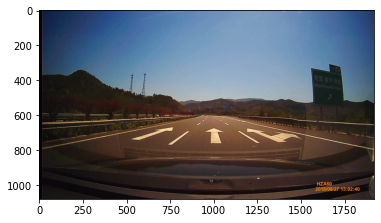

In [3]:
plt.imshow(org)

# Resize

In [4]:
resized = resize(pil_im,512)
resized.shape, org.shape

((512, 910, 3), (1080, 1920, 3))

# Grayscale

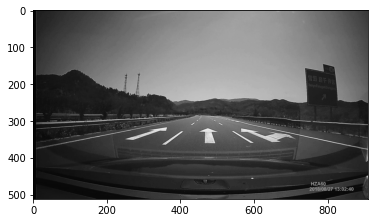

In [5]:
gray = rgb_to_gray(resized)
plt.imshow(gray,cmap='gray')

# Smoothing

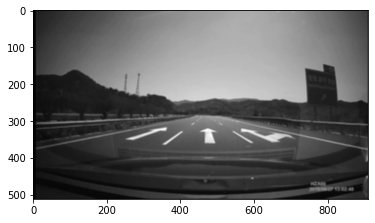

In [6]:
smooth = smoothing(gray)
plt.imshow(smooth,cmap='gray')

# Sobel Edge Detector

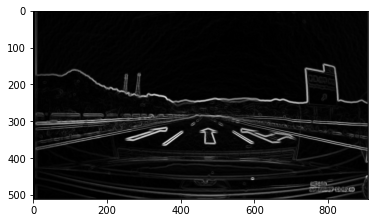

In [7]:
edge = sobel_edge_detector(smooth)
plt.imshow(edge,cmap='gray')

# Masking

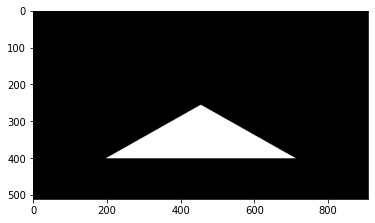

In [8]:
mask = fill_mask(edge)
plt.imshow(mask,cmap='gray')

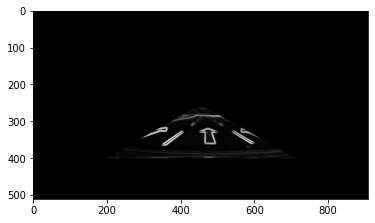

In [9]:
croped = apply_mask(edge, mask)
plt.imshow(croped,cmap='gray')

(300, 454)


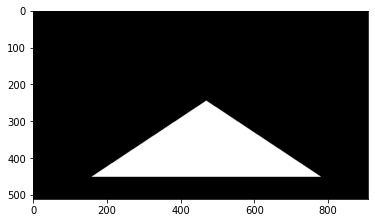

In [10]:
mask = TempMask(croped)
plt.imshow(mask,cmap='gray')

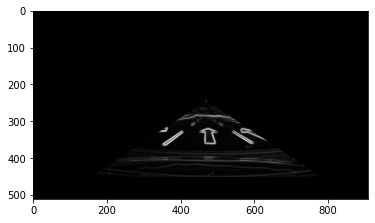

In [11]:
croped = apply_mask(edge, mask)
plt.imshow(croped,cmap='gray')

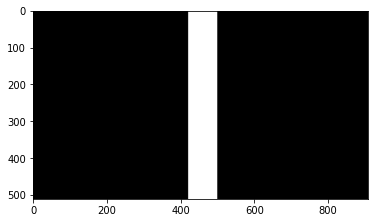

In [12]:
mask = squareMask(croped)
plt.imshow(mask,cmap='gray')

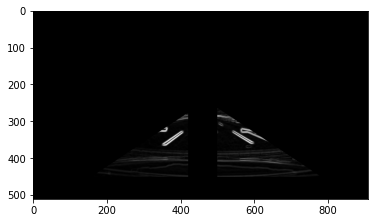

In [13]:
croped = reverse_apply_mask(croped, mask)
plt.imshow(croped,cmap='gray')

# Thresholding

In [14]:
t = otsu_threshold(croped)
t

Number of bins = 283


77.5

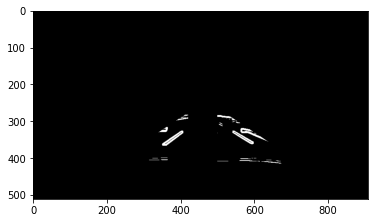

In [15]:
threshed = apply_threshold(croped, t)
plt.imshow(threshed,cmap='gray')

# Hough Transform

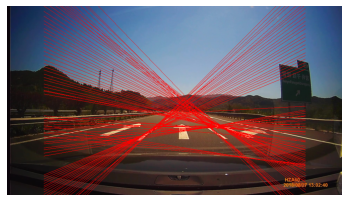

In [16]:
hough_space, point_stack = hough_lines(threshed, 50)

orig_line, gradients, line_info = draw_point_stack(resized, point_stack)

plt.imshow(orig_line)
plt.axis('off')
plt.show()

# Double Peak Grouping

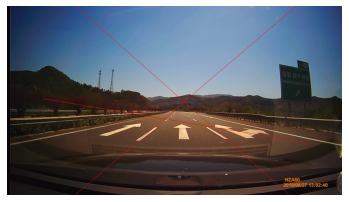

In [17]:
cleaned_point_stack = double_peak_grouping(point_stack)

orig_line, gradients, line_info = draw_point_stack(resized, cleaned_point_stack)

plt.imshow(orig_line)
plt.axis('off')
plt.show()

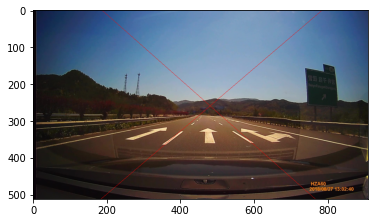

In [18]:
# Exclude lines not from lanes
h, w = resized.shape[:2]

neg_lines = [line for line in line_info if line[0] < -0.3]
pos_lines = [line for line in line_info if line[0] > 0.3]

cleaned_lines_img = resized.copy()

for coeff in pos_lines:
    m = coeff[0]
    b = coeff[1]
    y1 = m * 100 + b
    y2 = m * (w - 100) + b
    cv.line(cleaned_lines_img, (100, int(y1)), (w - 100, int(y2)), (255,0,0))
    
for coeff in neg_lines:
    m = coeff[0]
    b = coeff[1]
    y1 = m * 100 + b
    y2 = m * (w - 100) + b
    cv.line(cleaned_lines_img, (100, int(y1)), (w - 100, int(y2)), (255,0,0))

fig = plt.imshow(cleaned_lines_img)
plt.show()

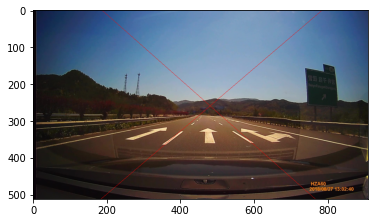

In [19]:
# Compute Average Lines
averaged_lines_img = resized.copy()

total_m = 0
total_b = 0
for coeff in pos_lines:
    total_m += coeff[0]
    total_b += coeff[1]
    
pos_m = total_m / len(pos_lines)
pos_b = total_b / len(pos_lines)

total_m = 0
total_b = 0
for coeff in neg_lines:
    total_m += coeff[0]
    total_b += coeff[1]
    
neg_m = total_m / len(neg_lines)
neg_b = total_b / len(neg_lines)

y1 = pos_m * 100 + pos_b
y2 = pos_m * (w - 100) + pos_b
cv.line(averaged_lines_img, (100, int(y1)), (w - 100, int(y2)), (255,0,0))

y1 = neg_m * 100 + neg_b
y2 = neg_m * (w - 100) + neg_b
cv.line(averaged_lines_img, (100, int(y1)), (w - 100, int(y2)), (255,0,0))

fig = plt.imshow(averaged_lines_img)
plt.show()

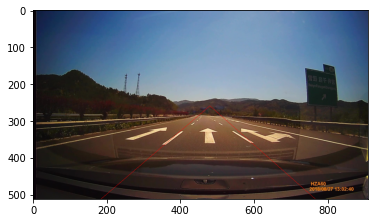

In [20]:
# Compute Vanishing Point
A = np.array([[-neg_m, 1], [-pos_m, 1]])
B = np.array([neg_b, pos_b])
C = np.linalg.solve(A, B)

vanished_img = resized.copy()


y1 = pos_m * (w - 100) + pos_b
cv.line(vanished_img, (int(C[0]), int(C[1])), (w - 100, int(y1)), (255,0,0))

y2 = neg_m * 100 + neg_b
cv.line(vanished_img, (100, int(y2)), (int(C[0]), int(C[1])), (255,0,0))

fig = plt.imshow(vanished_img)
plt.show()

# Color Detection

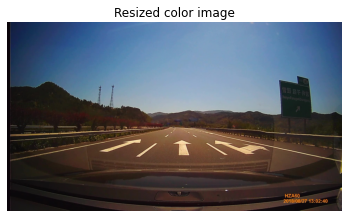

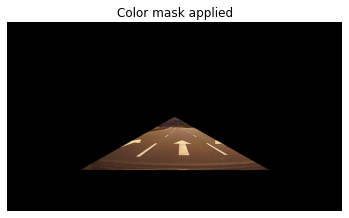

In [21]:
#add original image back
orig_img = resized.copy()
plt.imshow(orig_img)
plt.title('Resized color image')
plt.axis('off')
plt.show()

colorMask = fill_color_mask(orig_img)
plt.imshow(colorMask)
plt.title('Color mask')
plt.axis('off')
plt.show

croppedImageColor = apply_mask_color(orig_img, colorMask)
plt.imshow(croppedImageColor)
plt.title('Color mask applied')
plt.axis('off')
plt.show()

## RBG to HSV

In [22]:
hsv = rgb_to_hsv(croppedImageColor)

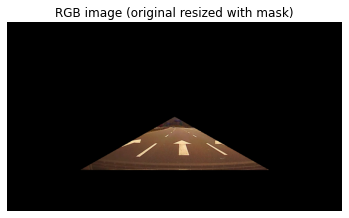

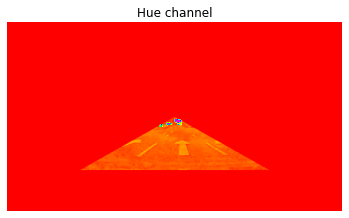

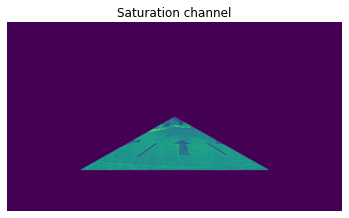

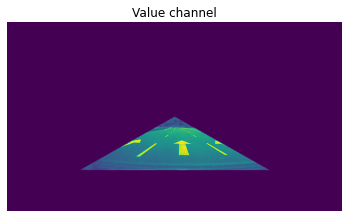

In [23]:
#extract hue, saturation, and value
hueImg = hsv[:,:,0]
satImg = hsv[:,:,1]
valImg = hsv[:,:,2]

plt.imshow(croppedImageColor)
plt.title("RGB image (original resized with mask)")
plt.axis('off')
plt.show()

plt.imshow(hueImg, cmap = 'hsv')
plt.title("Hue channel")
plt.axis('off')
plt.show()

plt.imshow(satImg)
plt.title("Saturation channel")
plt.axis('off')
plt.show()

plt.imshow(valImg)
plt.title("Value channel")
plt.axis('off')
plt.show()

## Histogram hue, saturation, and value

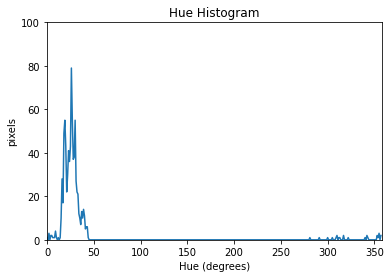

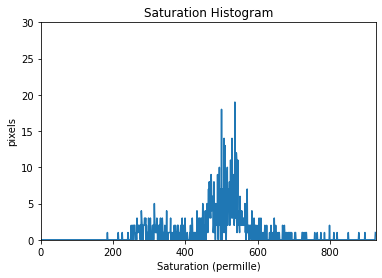

Value parameter = 650


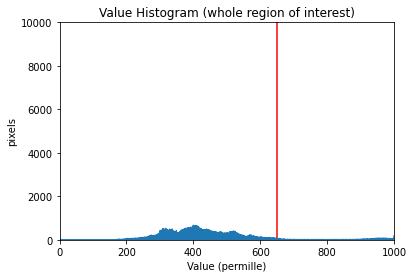

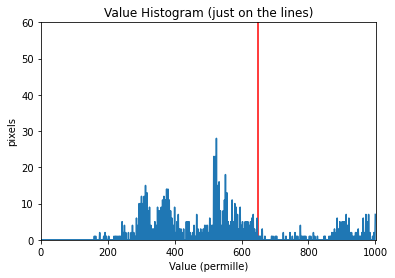

In [24]:
#use only the pixels that are both in the cropped section and on the lines
croppedHue = []
rows = colorMask.shape[0]
cols = colorMask.shape[1]
for y in range(rows):
    for x in range(cols):
        if (colorMask[y][x][0] != 0): #unmasked region
            yLine1 = int(neg_m * x + neg_b) #find lane line y value corresponding to the x value for the left lane line
            yLine2 = int(pos_m * x + pos_b) #find lane line y value corresponding to the x value for the right lane line
            if ((y == yLine1) or (y == yLine1 + 1) or (y == yLine1 - 1) or (y == yLine2) or (y == yLine2 + 1) or (y == yLine2 - 1)): #pixel on line plus or minus above and below pixel
                    croppedHue.append(hueImg[y][x])
croppedHue = np.array(croppedHue)

maxHueValue = int(np.amax(croppedHue)) + 1

hueHistogram, hueBinEdges = np.histogram(croppedHue, bins=maxHueValue, range=(0,maxHueValue))
# configure and draw the histogram figure
plt.figure()
plt.title("Hue Histogram")
plt.xlabel("Hue (degrees)")
plt.ylabel("pixels")
plt.xlim([0, maxHueValue])
plt.ylim([0, 100]) # must be changed manually after generating once for better visual analysis

plt.plot(hueBinEdges[0:-1], hueHistogram)  # <- or here
plt.show()

#use only the cropped section
croppedSat = []
for y in range(rows):
    for x in range(cols):
        if (colorMask[y][x][0] != 0): #unmasked region
            yLine1 = int(neg_m * x + neg_b) #find lane line y value corresponding to the x value for the left lane line
            yLine2 = int(pos_m * x + pos_b) #find lane line y value corresponding to the x value for the right lane line
            if ((y == yLine1) or (y == yLine1 + 1) or (y == yLine1 - 1) or (y == yLine2) or (y == yLine2 + 1) or (y == yLine2 - 1)): #pixel on line plus or minus above and below pixel
                croppedSat.append(satImg[y][x])
croppedSat = np.array(croppedSat)

maxSatValue = int(np.amax(croppedSat)) + 1

satHistogram, satBinEdges = np.histogram(croppedSat, bins=maxSatValue, range=(0,maxSatValue))
# configure and draw the histogram figure
plt.figure()
plt.title("Saturation Histogram")
plt.xlabel("Saturation (permille)")
plt.ylabel("pixels")
plt.xlim([0, maxSatValue])
plt.ylim([0, 30]) # must be changed manually after generating once for better visual analysis

plt.plot(satBinEdges[0:-1], satHistogram)  # <- or here
plt.show()

#use only the cropped section
croppedValWhole = []
for y in range(rows):
    for x in range(cols):
        if (colorMask[y][x][0] != 0): #unmasked region
            croppedValWhole.append(valImg[y][x])
            
croppedValWhole = np.array(croppedValWhole)

maxValWholeValue = int(np.amax(croppedValWhole)) + 1

valWholeHistogram, valWholeBinEdges = np.histogram(croppedValWhole, bins=maxValWholeValue, range=(0,maxValWholeValue))

valueParameter = np.argmax(valWholeHistogram) + 250
print(f'Value parameter = {valueParameter}')

# configure and draw the histogram figure
plt.figure()
plt.title("Value Histogram (whole region of interest)")
plt.xlabel("Value (permille)")
plt.ylabel("pixels")
plt.xlim([0, maxValWholeValue])
plt.ylim([0, 10000]) # must be changed manually after generating once for better visual analysis
plt.vlines(valueParameter, 0, 10000, colors = 'r')

plt.plot(valWholeBinEdges[0:-1], valWholeHistogram)  # <- or here
plt.show()

#use only the cropped section
croppedVal = []
for y in range(rows):
    for x in range(cols):
        if (colorMask[y][x][0] != 0): #unmasked region
            yLine1 = int(neg_m * x + neg_b) #find lane line y value corresponding to the x value for the left lane line
            yLine2 = int(pos_m * x + pos_b) #find lane line y value corresponding to the x value for the right lane line
            if ((y == yLine1) or (y == yLine1 + 1) or (y == yLine1 - 1) or (y == yLine2) or (y == yLine2 + 1) or (y == yLine2 - 1)): #pixel on line plus or minus above and below pixel
                croppedVal.append(valImg[y][x])
croppedVal = np.array(croppedVal)

maxValValue = int(np.amax(croppedVal)) + 1

valHistogram, valBinEdges = np.histogram(croppedVal, bins=maxValValue, range=(0,maxValValue))
# configure and draw the histogram figure
plt.figure()
plt.title("Value Histogram (just on the lines)")
plt.xlabel("Value (permille)")
plt.ylabel("pixels")
plt.xlim([0, maxValValue])
plt.ylim([0, 60]) # must be changed manually after generating once for better visual analysis
plt.vlines(valueParameter, 0, 100, colors = 'r')

plt.plot(valBinEdges[0:-1], valHistogram)  # <- or here
plt.show()

## Detection

There are 1 yellow pixels on the left lane line in the mask.
There are 100 white pixels on the left lane line in the mask.
There are 3 red pixels on the left lane line in the mask.
There are 369 dark pixels on the left lane line in the mask.
There are 0 pixels of other colors on the left lane line in the mask.

The color of the left lane marking is white.

There are 1 yellow pixels on the right lane line in the mask.
There are 44 white pixels on the right lane line in the mask.
There are 2 red pixels on the right lane line in the mask.
There are 325 dark pixels on the right lane line in the mask.
There are 0 pixels of other colors on the right lane line in the mask.

The color of the right lane marking is white.



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Image shown with just whites and yellows


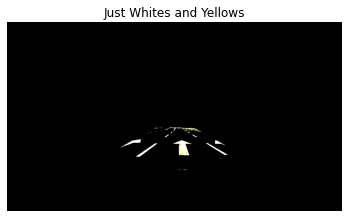

In [25]:
#currently can only detect yellow and white since it treats the unmarked pavement as red which will be fixed later, needs to be tested with multiple images

#number of pixels with that color
get_lane_color(rows, cols, colorMask, neg_m, neg_b, hueImg, satImg, valImg, "left", valueParameter)
get_lane_color(rows, cols, colorMask, pos_m, pos_b, hueImg, satImg, valImg, "right", valueParameter)

plt.imshow(croppedImageColor)
plt.axis('on')
plt.show

justWhitesAndYellows = np.zeros((rows,cols,3)) #color image
for y in range(rows):
    for x in range(cols):
        pixelColor = get_color(hueImg[y][x], satImg[y][x], valImg[y][x], valueParameter) #get the color (string) of that pixel
        if pixelColor == "yellow":
            #yellow = RGB: 255, 255, 0
            justWhitesAndYellows[y][x][0] = 255 #red
            justWhitesAndYellows[y][x][1] = 255 #green
            justWhitesAndYellows[y][x][2] = 0 #blue
        elif pixelColor == "white":
            #white = RGB: 255, 255, 255
            justWhitesAndYellows[y][x][0] = 255 #red
            justWhitesAndYellows[y][x][1] = 255 #green
            justWhitesAndYellows[y][x][2] = 255 #blue
        else:
            #black = RGB: 0, 0, 0
            justWhitesAndYellows[y][x][0] = 0 #red
            justWhitesAndYellows[y][x][1] = 0 #green
            justWhitesAndYellows[y][x][2] = 0 #blue

plt.imshow(justWhitesAndYellows)
plt.title("Just Whites and Yellows")
plt.axis('off')
plt.show
print('\nImage shown with just whites and yellows')